# Project 2: fire in the nature park

Laura Santa Cruz<br>
Intelligent data Analysis and Machine learning <br>
University of Potsdam 2024<br>

## 1. Introduction and problem setting

The administration of the nature park Montesinho wants to **predict wild fires based on wheather data of the Fire-Wheather-Index (FWI)**. The aim is to recognize the affected area and consequently the intensity of the imminent wild fire as early as possible in order to be able to adequatly assess the danger caused by the fire.

Data: 
    Collected from 517 wild fires containing following features: 

    X       X-coordinate of the fire in the park: 1 to 9 
    Y       Y-coordinate of the fire in the park: 2 to 9 
    month   month: ”jan“ to ”dec"
    day     day: ”mon“ bis ”sun“
    FFMC    FFMC index of the FWI system: 18.7 to 96.2
    DMC     DMC index of the FWI system: 1.1 bis 291.3  
    DC      DC index of the system: 7.9 bis 860.6
    ISI     ISI index of the FWI systems: 0.0 to 56.1
    temp    temperature in degrees Celsius: 2.2 to 33.3
    RH      relative humidity in %: 15 to 100
    wind    wind velocity in km/h: 0.4 to 9.4
    rain    rainfall in mm/m2: 0.0 to 6.4
    area    forest area that has been burnt in hectare (ha): 0.09 to 1090.84

Task:
    Develop a model that predicts the burnt forest area as accurately as possible from the given data.

### 1.1 Loading and inspection of the data

In order to have an overview of the dataset, some checks will be performed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [10]:
fires = pd.read_csv('fires.csv')
print(fires)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


In [11]:
fires.describe() #for summary statistics

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Check for missing values:

In [12]:
if any(fires.isnull().sum()) != 0:
    print(fires.isnull().sum())
else: 
    print("No missing values.")


No missing values.


As we can see from this initial checks, the variables 'month' and 'day' are categorical so we will need to enconde them in order to use them in the model. We can also plot these variables to visualize any months or days where fires happen more frequently:

Text(0.5, 1.0, 'Distribution of Days')

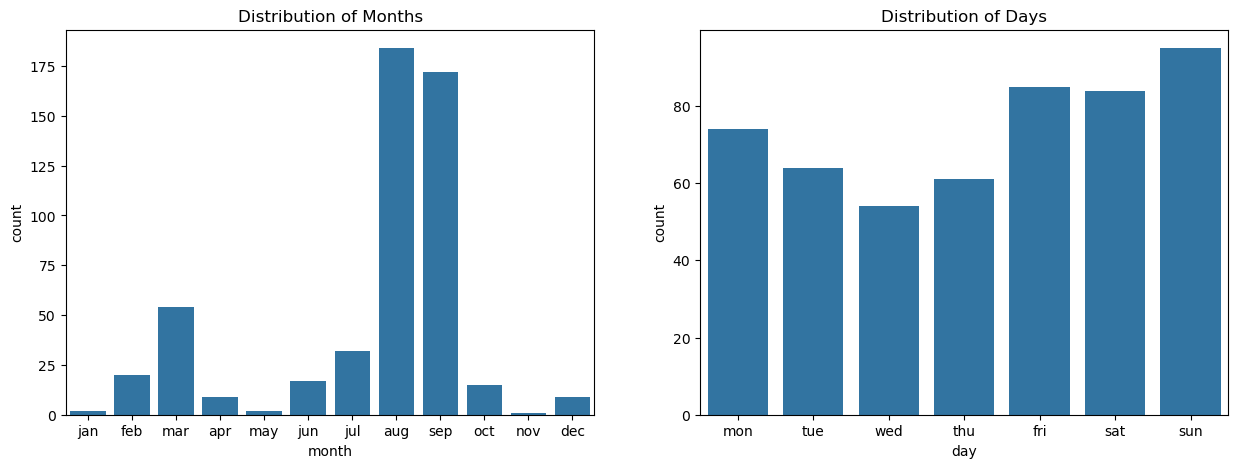

In [30]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Convert month and day columns to ordered categorical types (for plotting purposes)
fires['month'] = pd.Categorical(fires['month'], categories=month_order, ordered=True)
fires['day'] = pd.Categorical(fires['day'], categories=day_order, ordered=True)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(fires, x='month')
plt.title("Distribution of Months")

plt.subplot(1,2,2)
sns.countplot(fires, x='day')
plt.title("Distribution of Days")

From plotting 'month' and 'day' we can see most fires happen during the months of August and September and during the weekends (Friday, Saturday Sunday). <br><br>
One-hot encoding will be used, so no misleading assumptions of magnitude are introduced and to ensure each category is treated independently:

In [37]:
# Convert the columns back to regular categorical types for one-hot encoding
fires['month'] = pd.Categorical(fires['month'], categories=month_order, ordered=False)
fires['day'] = pd.Categorical(fires['day'], categories=day_order, ordered=False)

fires = pd.get_dummies(fires, columns=['month','day'], drop_first=False)
fires.head(5)

KeyError: 'month'

For the numerical variables, some variables like 'FFMC' (from 18.7 to 96.2) or 'DC' (from 7.9 to 860.6) have different varying scales so they need to be normalized. We can also check the distirbuion of the numerical data to look for outliers and non-normal distributions:

In [ ]:
numerical_columns = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']


## 2. Data preparation and normalization

## 3. Model creation

## 4. Summary

## 5. Conclusion